# Real-Time Speech Analysis
A few tools for real-time speech formant analysis, which make it easy and convenient to see what parselmouth's (Praat's) measurements look like.
## Setup

In [1]:
import numpy as np

# For real-time plotting
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import pyaudio
audio = pyaudio.PyAudio()

import parselmouth # For Praat software

## Real-time waveform

<IPython.core.display.Javascript object>


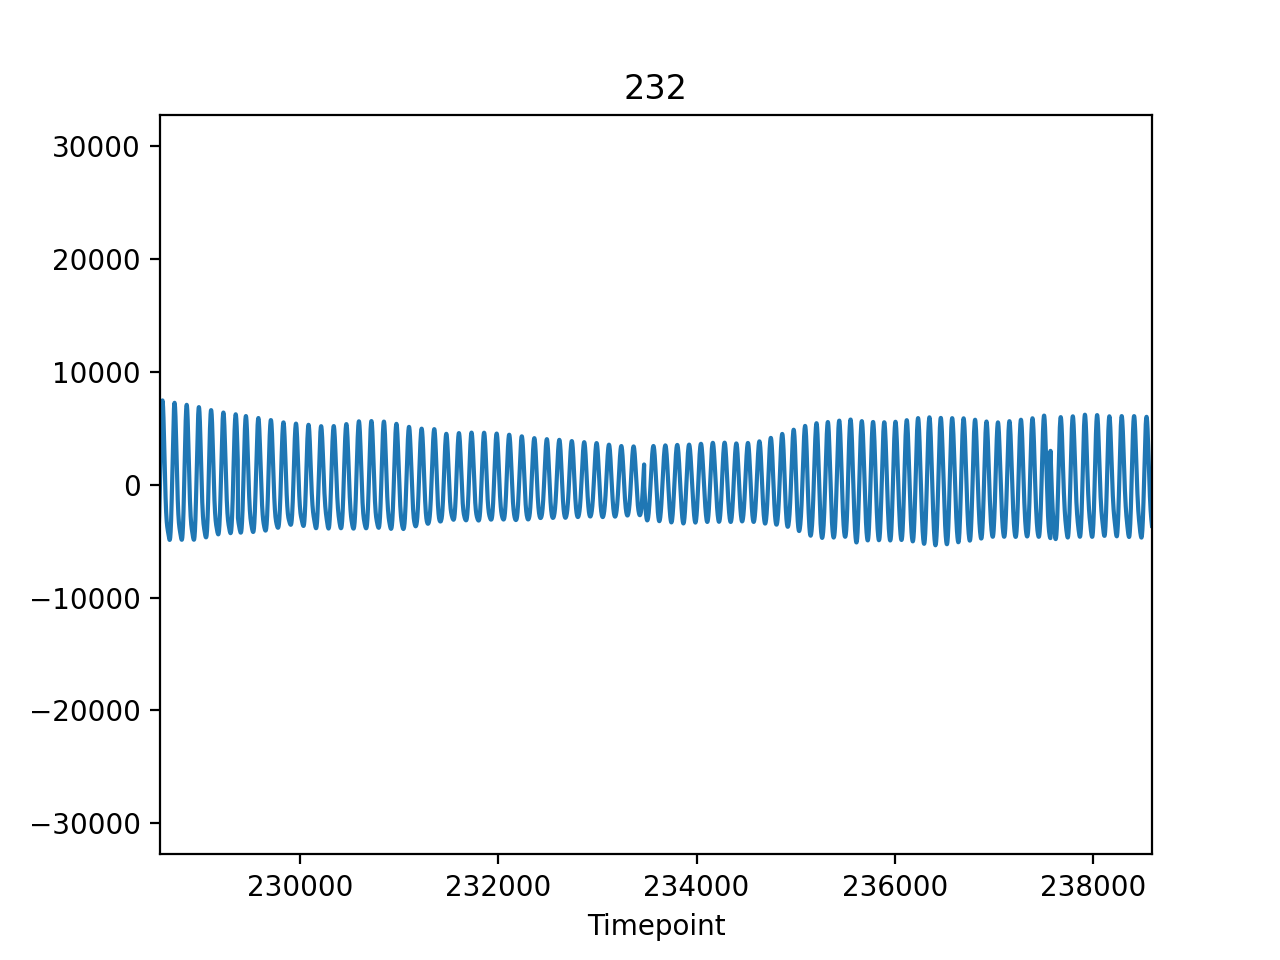

In [2]:
# Setup
fig, ax = plt.subplots()
x = []
y = []
ln, = ax.plot([], [])

ax.set_xlim(0, 10000)
ax.set_ylim(-32768, 32767)
ax.set_xlabel("Timepoint")

stream = audio.open(format=pyaudio.paInt16, channels=1,
                    rate=44100, input=True,
                    frames_per_buffer=1024)

# Update function
def update(frame):
    ax.set_title(frame)
    
    data = stream.read(1024, exception_on_overflow=False)
    audio_data = np.frombuffer(data, dtype=np.int16)
    
    x.extend(range(frame*1024, (frame+1)*1024))
    y.extend(audio_data)
    
    ln.set_data(x, y)
    
    # "Scrolling" effect
    if x[-1] >= ax.get_xlim()[1]:
        ax.set_xlim(x[-1] - 10000, x[-1])
    
    return ln,

ani = animation.FuncAnimation(fig, update, interval=1, blit=True, cache_frame_data=False)
plt.show()

## Real-time pitch extraction

<IPython.core.display.Javascript object>


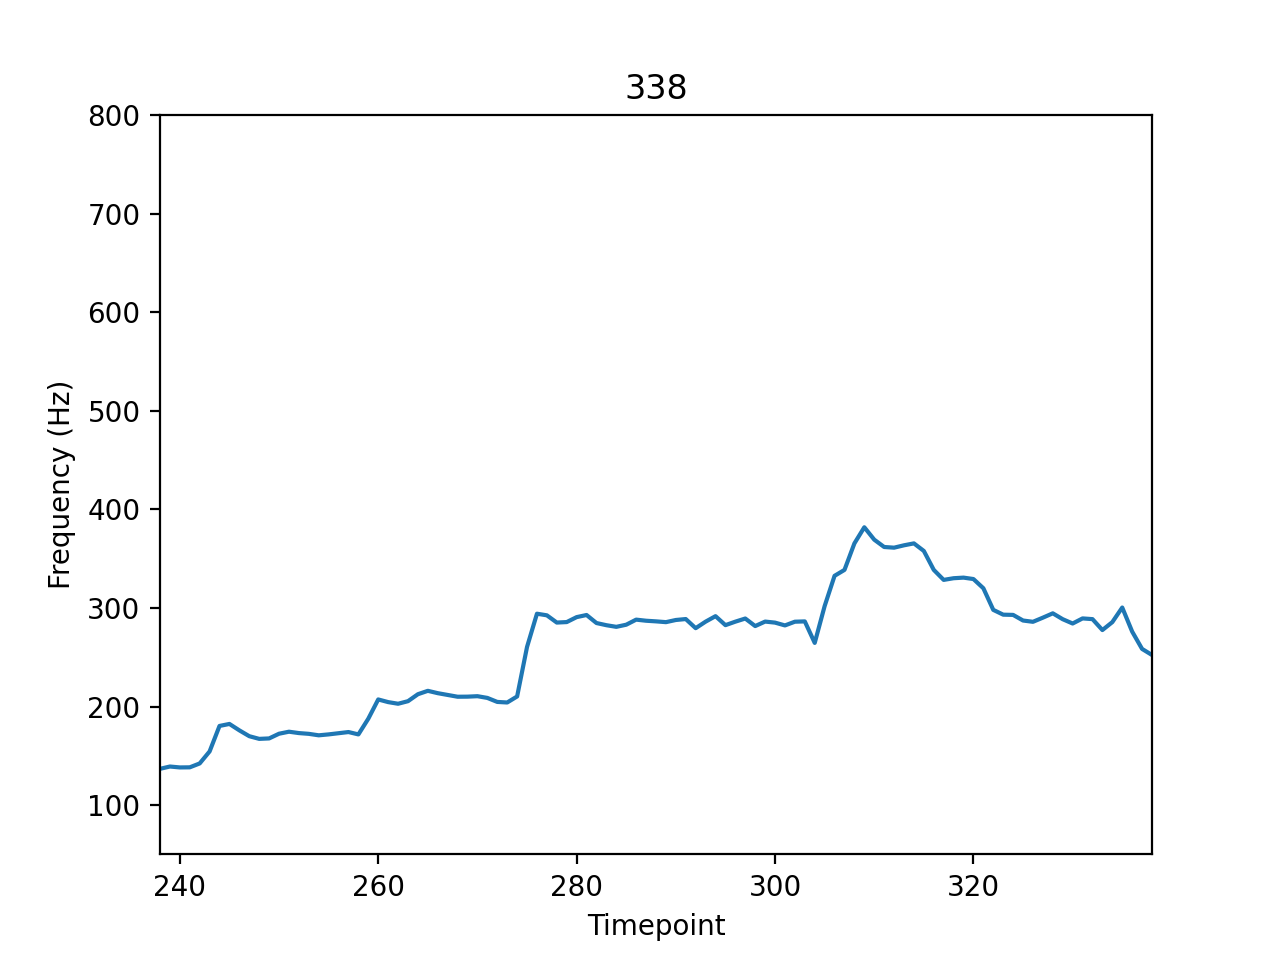

In [3]:
# Setup
fig, ax = plt.subplots()
x = []
y = []
ln, = ax.plot([], [])

ax.set_xlim(0, 100)
ax.set_ylim(50, 800)
ax.set_xlabel("Timepoint")
ax.set_ylabel("Frequency (Hz)")

stream = audio.open(format=pyaudio.paInt16, channels=1,
                    rate=44100, input=True,
                    frames_per_buffer=1024)

# Update function
def update(frame):
    ax.set_title(frame)
    
    data = stream.read(2048, exception_on_overflow=False)
    audio_data = np.frombuffer(data, dtype=np.int16)
    sound = parselmouth.Sound(audio_data, 44100)
    
    # Get f0 using Praat's pitch extraction
    pitch = sound.to_pitch()
    f0_values = pitch.selected_array['frequency']
    f0_values = np.where(f0_values > 0, f0_values, np.nan)
    
    x.append(frame)
    y.append(np.mean(f0_values))
    
    ln.set_data(x, y)
    
    # "Scrolling" effect
    if len(x) > 0:
        if x[-1] >= ax.get_xlim()[1]:
            ax.set_xlim(x[-1] - 100, x[-1])
    
    return ln,

ani = animation.FuncAnimation(fig, update, interval=10, blit=True, cache_frame_data=False)
plt.show()

## Real-time formant extraction

<IPython.core.display.Javascript object>


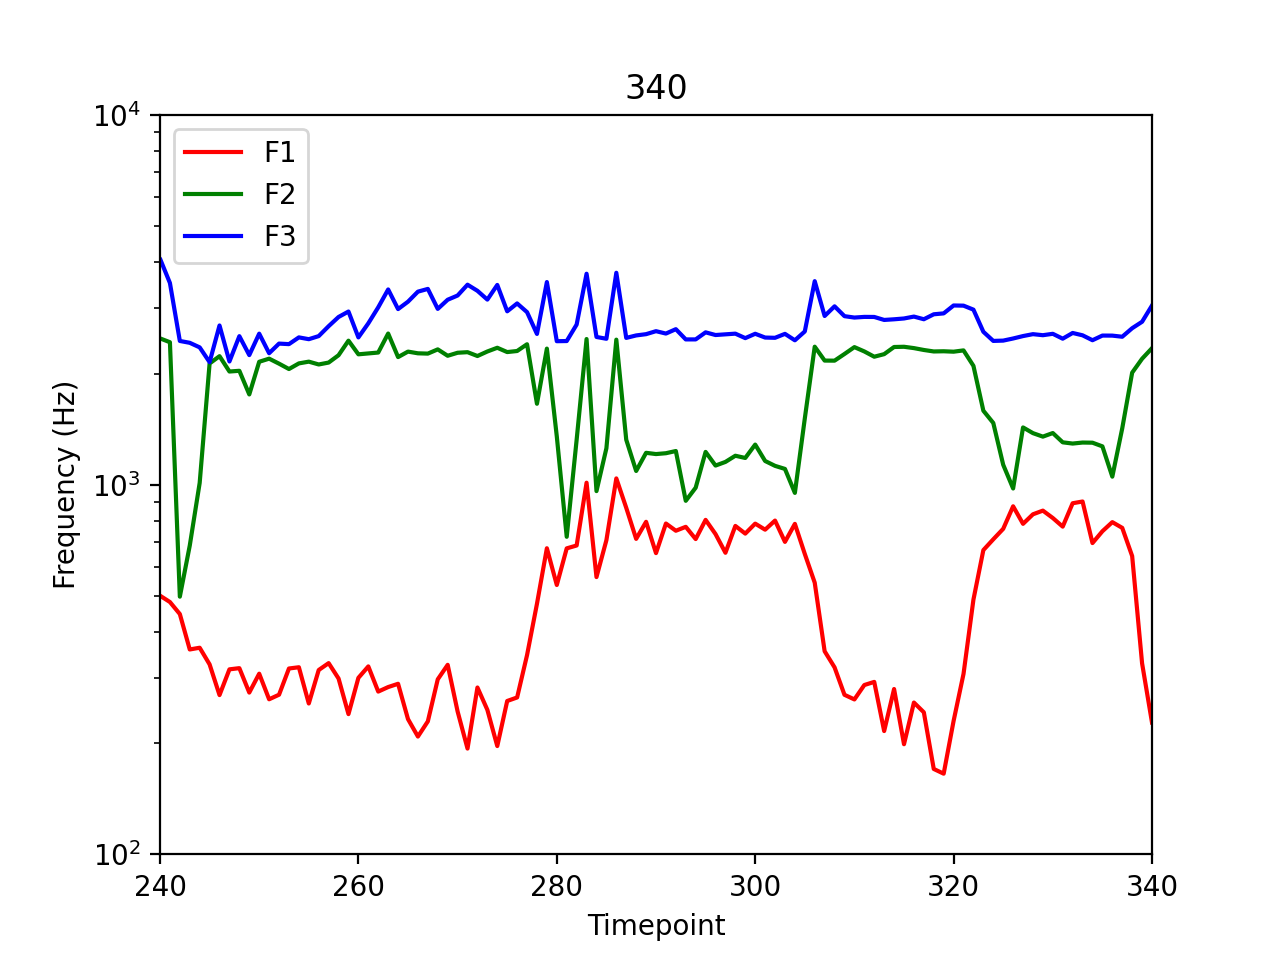

In [4]:
# Setup
fig, ax = plt.subplots()
x = []
y1 = []
y2 = []
y3 = []

ln1, = ax.plot([], [], label="F1", color="r")
ln2, = ax.plot([], [], label="F2", color="g")
ln3, = ax.plot([], [], label="F3", color="b")

ax.set_xlim(0, 100)
ax.set_ylim(100, 10000)
ax.legend(loc=2)
ax.set_yscale("log")
ax.set_xlabel("Timepoint")
ax.set_ylabel("Frequency (Hz)")

stream = audio.open(format=pyaudio.paInt16, channels=1,
                    rate=44100, input=True,
                    frames_per_buffer=1024)

# Update function
def update(frame):
    ax.set_title(frame)
    
    data = stream.read(1024, exception_on_overflow=False)
    audio_data = np.frombuffer(data, dtype=np.int16)
    sound = parselmouth.Sound(audio_data, 44100)
    formants = sound.to_formant_burg(time_step=0.01)
        
    f1_values = []
    f2_values = []  
    f3_values = []
        
    for t in np.arange(0, sound.xmax, 0.01):
        f1 = formants.get_value_at_time(1, t)
        f2 = formants.get_value_at_time(2, t)
        f3 = formants.get_value_at_time(3, t)
        if not np.isnan(f1) and not np.isnan(f2) and not np.isnan(f3):
            f1_values.append(f1)
            f2_values.append(f2)
            f3_values.append(f3)
            
    x.append(frame)
    y1.append(np.mean(f1_values))
    y2.append(np.mean(f2_values))
    y3.append(np.mean(f3_values))
    
    ln1.set_data(x, y1)
    ln2.set_data(x, y2)
    ln3.set_data(x, y3)
    
    # "Scrolling" effect
    if len(x) > 0:
        if x[-1] >= ax.get_xlim()[1]:
            ax.set_xlim(x[-1] - 100, x[-1])
    
    return ln1, ln2, ln3

ani = animation.FuncAnimation(fig, update, interval=10, blit=True, cache_frame_data=False)
plt.show()

## Real-time vowel chart plotting

<IPython.core.display.Javascript object>


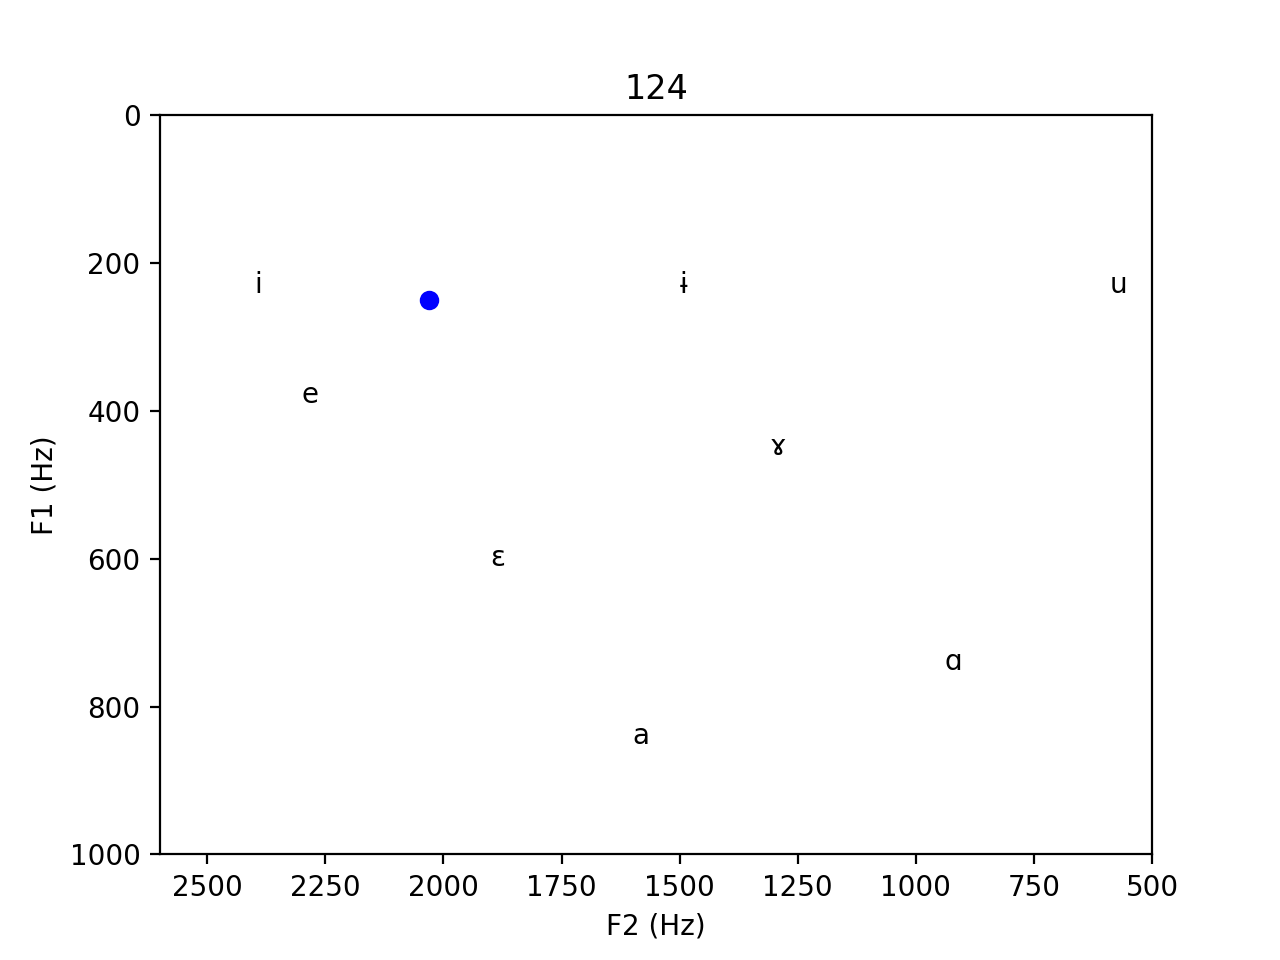

In [5]:
# Setup
fig, ax = plt.subplots()
scatter, = ax.plot([], [], "bo")

# Set axis limits based on typical formant ranges
ax.set_xlim(2600, 500)
ax.set_ylim(1000, 0)
ax.set_xlabel("F2 (Hz)")
ax.set_ylabel("F1 (Hz)")

ax.annotate("i", (2400, 240))
ax.annotate("e", (2300, 390))
ax.annotate("ε", (1900, 610))
ax.annotate("u", (590, 240))
ax.annotate("a", (1600, 850))
ax.annotate("ɑ", (940, 750))
ax.annotate("ɤ", (1310, 460))
ax.annotate("ɨ", (1500, 240))

stream = audio.open(format=pyaudio.paInt16, channels=1,
                    rate=44100, input=True,
                    frames_per_buffer=1024)

# Update function
def update(frame):
    ax.set_title(frame)
    
    data = stream.read(1024, exception_on_overflow=False)
    audio_data = np.frombuffer(data, dtype=np.int16)
    sound = parselmouth.Sound(audio_data, 44100)
    
    formants = sound.to_formant_burg(time_step=0.01) 
    
    f1_values = []
    f2_values = []  
        
    for t in np.arange(0, sound.xmax, 0.01):
        f1 = formants.get_value_at_time(1, t)
        f2 = formants.get_value_at_time(2, t)
        if not np.isnan(f1) and not np.isnan(f2):
            f1_values.append(f1)
            f2_values.append(f2)
            
    f1 = np.mean(f1_values)
    f2 = np.mean(f2_values)
    scatter.set_data([f2], [f1])
    
    return scatter,

ani = animation.FuncAnimation(fig, update, interval=10, blit=True, cache_frame_data=False)
plt.show()